### Analyzing the best solutions found

| Experiment ID | Min DF | Binary | Vectorizer | Method | Best k |
|---------------|--------|--------|------------|--------|--------|
| 1463          | 0.35   | True   | NCut       | NMF    | 7      |
| 26            | 0.05   | True   | Count      | LDA    | 12     |
| 24            | 0.05   | True   | Count      | NMF    | 15     |

#### Import libraries

In [1]:
#DB
from questions.models import Solution, Cluster
import psycopg2

# Helpers
import numpy as np
import pickle
import base64
import pandas as pd

# Preprocessing
import tokenize
from tokenizer import create_bag_of_words
from sklearn.feature_extraction.text import CountVectorizer
from vectorizer import NCutVectorizer

# Distance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, pairwise_kernels

# Learning
from clustering import Clustering
from questions.sampling import get_next_sample
from analyzer import python_analyzer

# Visualization
from plot2d import Plot2D
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport
import pyLDAvis.sklearn
import matplotlib.patches as patches


%matplotlib inline

In [2]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=last_id)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print("Problems to be ignored: %d" % problems.count())

problems = Problem.objects.filter(id__lte=last_id)
# problems = Problem.objects.all()
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be ignored: 591
Problems to be used: 132
Solutions to be used: 54
Got 54 documents


***Limitações do parser:***

***1. Variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

***2. Não é possível processar solução sintaticamente errada. Talvez uma tokenização básica possa ajudar quando esse for o caso e já é uma indicação de que está errado.***

# Connect to DB

In [3]:
connection = psycopg2.connect(user = "machineteaching",
                                  password = "",
                                  host = "localhost",
#                                   port = "5432",
                                  database = "machineteaching")
connection.autocommit=True
cursor = connection.cursor()

In [11]:
def get_where_items(exp_id):
    cols = ["vectorizer", "min_df", "is_binary", "distance", "method", "dataset", "k", "model", "X"]
    query = "SELECT %s from EXPERIMENTS_STABILITY where experiment_id = %s" % (", ".join(cols), exp_id) 
    cursor.execute(query)
    where_items = cursor.fetchall()
    return where_items

def analyze(solutions, where_items, exp_id):
    v = eval(where_items[0][0])
    m = where_items[0][1]
    b = where_items[0][2]
    dist = where_items[0][3]
    method = where_items[0][4]
    k = where_items[0][6]
    model_db = pickle.loads(base64.b64decode(where_items[0][7]))
    X = np.asarray(where_items[0][8])

    train_data_features, vectorizer, feature_names = create_bag_of_words(solutions, v, binary=b, min_df=m)
    clustering = Clustering(train_data_features, k, metric=dist)
    clustering.seed = model_db.random_state
    
    model, document_topic, word_topic = getattr(clustering, method)()
    
    savefig='problems_20190101_%s_%s_exp_%s_%s_document_topic_distribution' % (method, clustering.seed, 
                                                                                   exp_id, clustering.k)
    clustering.plot_topic_distribution(title="Topic distribution per document", ylabel="Document ID", savefig=savefig, cmap='Blues')

    print("Count per class:")
    clusters = clustering.document_topic.argmax(axis=1)
    counts = np.unique(clusters, return_counts=True)
    print(counts)
    return clustering, method, feature_names, model

#### Visualization
Reduce to 2 dimensions

In [5]:
def plot_reduction(clustering, method, exp_id):
    cluster_names = ["Topic %d" % (i+1) for i in range(clustering.k)]
    doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
    doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
    handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
    handler._generate_random_state()
    solution_sample = clustering.X

    # Reduce using PCA
    handler.reduce_pca(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_pca' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    # Reduce using SVD
    handler.reduce_svd(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_svd' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    # Reduce using TSNE
    handler.reduce_tsne(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_tsne' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    # Reduce using MDS
    handler.reduce_mds(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_mds' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    sample = handler.X
    y = clustering.document_topic.argmax(axis=1)
    return sample, y

#### Generate PDF report

In [6]:
def pdf(sample, y, clustering, method, exp_id):
    # Create X as an empty belief state (X is the machine's model of the student's distribution)
    X = np.zeros(clustering.document_topic.shape) # nS x nC
    print(X.shape)

    # Create Y as a document_topic matrix. For the first version, each document belongs to one topic
    Y_col = clustering.document_topic.argmax(axis=1) # nS x nC
    Y = np.zeros(clustering.document_topic.shape)
    for idx in range(Y.shape[0]):
        Y[idx, Y_col[idx]] = 1

    # Create W as a similarity matrix
    W = cosine_similarity(clustering.X) # nS x nS
    print(W.shape)

    with open('similarity.pkl', 'wb') as picklefile:
        pickle.dump(W, picklefile)

    # Set L as an unlabelled set
    L = []
    
    doc = PDFReport()
    
    for i in range(54):
        # Plot sample
        sample_id = get_next_sample(X, Y, W, L)

        # Print question
        problem = "Cluster: " + str(y[sample_id] + 1) + "\n" + questions[sample_id]
        solution = solutions[sample_id]

        # Plot sample
        fig = plt.figure(figsize=(9,13))

        # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
        [nS, nC] = X.shape
        # Create the set of unlabelled samples (U)
        U = np.setdiff1d(np.arange(nS), L)

        # Plot unlabeled samples
        plt.scatter(x=sample[U,0], y=sample[U,1], s=100)

        # Color by class the ones already labeled
        if L:
            a = plt.scatter(x=sample[L,0], y=sample[L,1], c=y[L], s=100)

        # Star the queried sample
        plt.scatter(x=sample[sample_id,0], y=sample[sample_id,1], color='r', marker=r'$\star$', s=400)

        # Save figure
        plt.savefig("images/solution_%d.eps" % sample_id, format='eps')
        plt.savefig("images/solution_%d.png" % sample_id, format='png')
        plt.close(fig)
    #     print("Question %d" % sample_id)

        # Print question
    #     problem = questions[sample_id]
    #     solution = solutions[sample_id]

        # Suppose that the student gets it correctly
        # Update X matrix
        X[sample_id] = Y[sample_id]
        L.append(sample_id)
        doc.append_solution(sample_id, problem, solution)
    #     print(X)

    doc.generate_tex("problems_20190101_%s_%s_exp_%s_%s" % (method, clustering.seed, 
                                                                    exp_id, clustering.k))

#### Words per topic

In [7]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=0)
    matrix_norm = matrix / row_sums[np.newaxis, :]
    return matrix_norm

def sort_distribution(df, columns, MIN_PROB=0.3):
    ids = []

    for col in columns:
        ids = ids + df[df[col] > MIN_PROB].sort_values([col], ascending=False).index.tolist()
    
    for col in columns:
        ids = ids + df.sort_values([col], ascending=False).index.tolist()

    index = df.loc[ids].index.drop_duplicates()
    df_sorted = df.loc[index]
    return df_sorted

def plot_words_per_topic(clustering, feature_names, exp_id, topics=None, size=200, figsize=(8,18), cutoff=False, 
                         ylabel=True, mark_exclusive=False):
    # word_topic_norm = normalize_per_row(word_topic)
    
    x = ["Topic %d" % (idx+1) for idx in range(clustering.document_topic.shape[1])]
    y = feature_names
    word_topic_df = pd.DataFrame(clustering.word_topic, index=y, columns=x)
    if topics:
        x = ["Topic %d" % (idx+1) for idx in topics]
        word_topic_df = word_topic_df[x]
    
    # word_topic_df = pd.DataFrame(word_topic_norm, index=y, columns=x)
    
    avg_weight = np.percentile(clustering.word_topic, 75)
    word_topic_df = sort_distribution(word_topic_df, x, MIN_PROB=avg_weight)
    
    if cutoff:
        word_topic_df['keep'] = word_topic_df.apply(lambda row: not all([(x < 1) for x in row]), axis = 1)
        word_topic_df = word_topic_df[word_topic_df['keep'] == True]
        word_topic_df.drop('keep', inplace=True, axis=1)
        
    plt.figure(figsize=figsize)

    points = word_topic_df.values
    cols = word_topic_df.columns
    rows = word_topic_df.index

    plt.xticks(range(0,len(cols)), cols, fontsize=16)
    if ylabel:
        plt.yticks(range(0,len(rows)), rows, fontsize=18)
    else:
        plt.yticks(range(0,len(rows)), '')
        
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        bottom=False,      # ticks along the bottom edge are off
        top=True,         # ticks along the top edge are off
        labelbottom=False,
        labeltop=True)
    plt.grid(alpha=0.3)

    for x_item in range(len(cols)):
        for y_item in range(len(rows)): 
            
            if points[y_item, x_item] > avg_weight:
                
                # Get terms that are exclusive for the given topic
                exclusive = []
                for x_item_comp in range(len(cols)):
                    if x_item != x_item_comp and points[y_item, x_item_comp] <= avg_weight:
                        exclusive.append('g')       
                if mark_exclusive and len(exclusive) == (len(cols)-1):
                    c = 'g'
                else:
                    c = 'r'
                
            else:
                c = 'b'
            plt.scatter(x_item, y_item, s=points[y_item, x_item]*size, c=c)

    plt.gca().invert_yaxis()
#     plt.yticks(rotation='45')
    plt.xticks(rotation='45')
    
#     # Create a Rectangle patch
#     rect = patches.Rectangle((1.5,8.5),2,11,linewidth=10,edgecolor='gray',facecolor='none')
#     # Add the patch to the Axes
#     plt.gca().add_patch(rect)

    
    plt.tight_layout()
    if mark_exclusive:
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic_exclusive.png' % (method, clustering.seed, exp_id))
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic_exclusive.eps' % (method, clustering.seed, exp_id), format='eps')
    else:
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic.png' % (method, clustering.seed, exp_id))
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic.eps' % (method, clustering.seed, exp_id), format='eps')
    plt.show()
    
def print_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        names = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(names)
        message += ", ".join(names)
        print(message)
    print()
    return top_words

#### pyLDAvis

In [20]:
def LDAvis(solutions, where_items, model, R=0):
    v = eval(where_items[0][0])
    m = where_items[0][1]
    b = where_items[0][2]
    dist = where_items[0][3]
    method = where_items[0][4]
    k = where_items[0][6]
    model_db = pickle.loads(base64.b64decode(where_items[0][7]))
    X = np.asarray(where_items[0][8])

    vectorizer = CountVectorizer(analyzer = python_analyzer,
                                 binary=b,
                                 min_df=m)
    train_data_features = vectorizer.fit_transform(solutions)
 
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(model, train_data_features, vectorizer, mds='mmds', sort_topics=False, R=R)
    return panel

# Experiment 1463

- Min DF: 0.35
- Binary: True
- Vectorizer: NCut
- Method: NMF
- Best k: 7

Conditions
('CountVectorizer', 0.05, True, 'euclidean', 'lda', 'dataset9', 13)


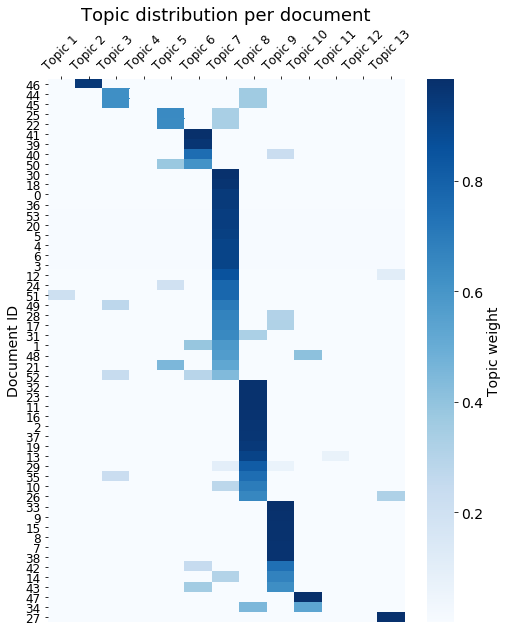

Count per class:
(array([ 1,  2,  4,  5,  6,  7,  8,  9, 12]), array([ 1,  2,  2,  4, 21, 12,  9,  2,  1]))
Number of terms: 236


/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 432x288 with 0 Axes>

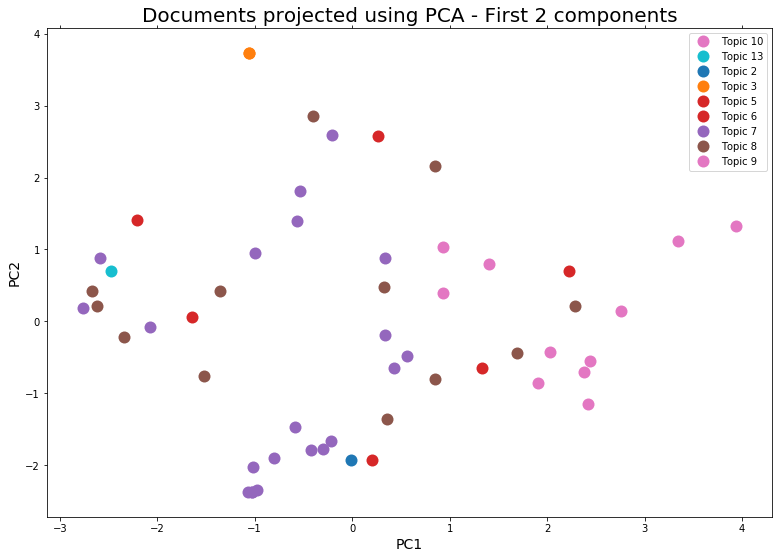

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


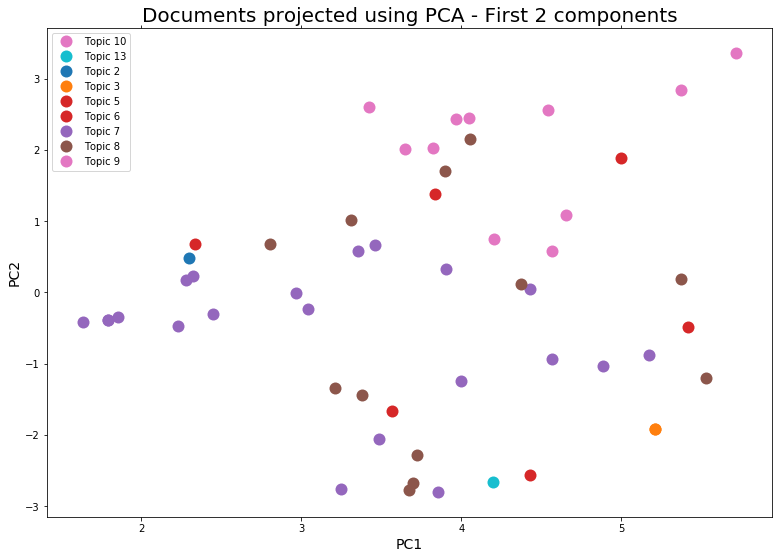

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


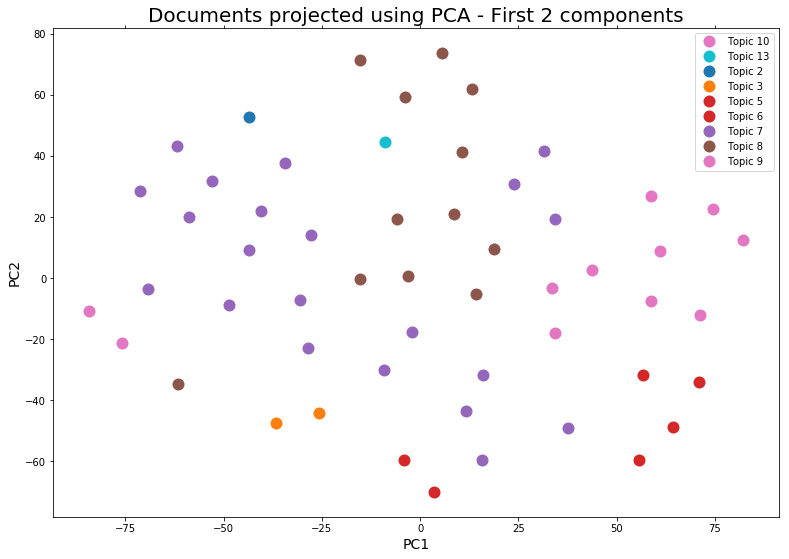

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


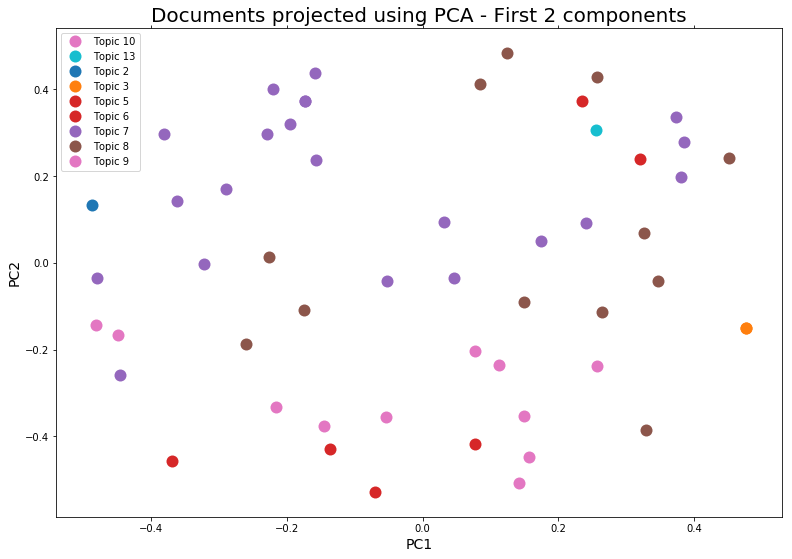

(54, 13)
(54, 54)


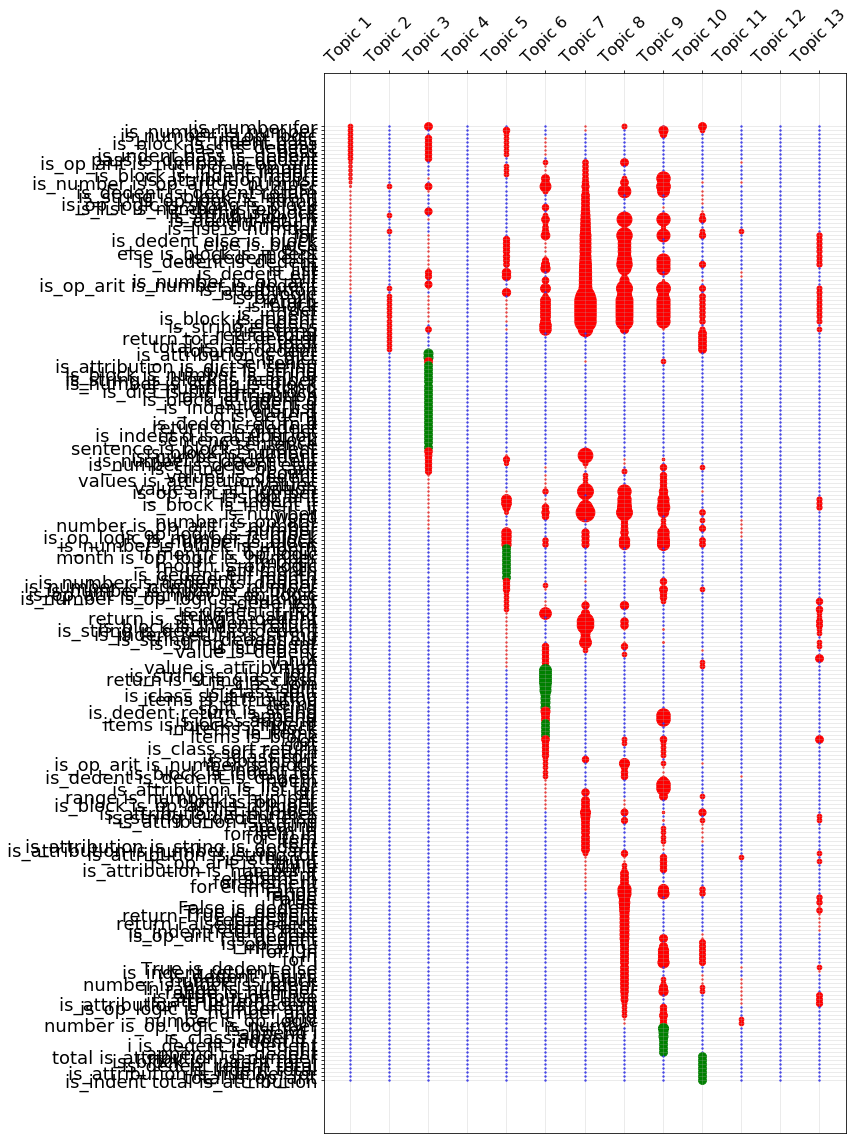

Topic #0: is_number for, is_number is_number, is_number is_op_logic, pass, pass is_dedent, is_indent pass is_dedent, is_block is_indent pass, is_indent pass, pass is_dedent is_dedent, is_op_arit is_number is_op_arit
Topic #1: is_op_arit, return, is_block, def, is_indent, is_block is_indent, is_dedent, int, is_attribution, is_string is_class
Topic #2: is_attribution is_dict, is_dict, sentence, is_dict is_string, is_block is_number is_string, is_string is_block is_number, is_attribution is_dict is_string, is_dict is_string is_block, is_number is_string, is_number is_string is_block
Topic #3: is_op_arit is_string, is_attribution is_list, is_block, def, is_block is_indent, is_dedent, is_indent, return, is_op_arit, is_list is_number
Topic #4: is_indent if, is_block is_indent if, is_op_logic is_number, is_op_logic is_number is_block, is_number is_block, is_number is_block is_indent, is_dedent elif, elif, is_op_logic, month is_op_logic
Topic #5: join, is_class join, return is_string is_class,

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.018418  0.162335       1        1   0.783430
1      0.075544 -0.014031       2        1   1.075154
2     -0.017506  0.359397       3        1   5.933774
3      0.003984  0.062858       4        1   0.204677
4     -0.259007  0.112429       5        1   5.283159
5     -0.019473 -0.274039       6        1  10.749100
6     -0.173236 -0.167666       7        1  24.715743
7      0.045130 -0.181296       8        1  23.649862
8      0.178265 -0.153469       9        1  19.055473
9      0.243377  0.019772      10        1   4.790059
10     0.021404  0.087265      11        1   0.405344
11     0.003984  0.062858      12        1   0.204677
12    -0.120885 -0.076412      13        1   3.149546, topic_info=    Category       Freq                            Term      Total  loglift  \
146  Default  36.000000                      is_op_arit  36.000000  30.0000   
87   Default  50.000000                       is_dedent  50.000000  29.0000   
104  Default  50.000000                       is_indent  50.000000  28.0000   
66   Default  50.000000                        is_block  50.000000  27.0000   
15   Default  50.000000                             def  50.000000  26.0000   
67   Default  50.000000              is_block is_indent  50.000000  25.0000   
201  Default  50.000000                          return  50.000000  24.0000   
79   Default  19.000000                        is_class  19.000000  23.0000   
50   Default  36.000000                  is_attribution  36.000000  22.0000   
49   Default   9.000000                             int   9.000000  21.0000   
162  Default  23.000000                       is_string  23.000000  20.0000   
109  Default  20.000000                    is_indent if  20.000000  19.0000   
70   Default  20.000000           is_block is_indent if  20.000000  18.0000   
73   Default  17.000000       is_block is_indent return  17.000000  17.0000   
115  Default  17.000000                is_indent return  17.000000  16.0000   
57   Default  14.000000          is_attribution is_list  14.000000  15.0000   
156  Default  25.000000                     is_op_logic  25.000000  14.0000   
157  Default  15.000000           is_op_logic is_number  15.000000  13.0000   
159  Default  14.000000  is_op_logic is_number is_block  14.000000  12.0000   
168  Default   8.000000              is_string is_class   8.000000  11.0000   
131  Default  20.000000              is_number is_block  20.000000  10.0000   
132  Default  20.000000    is_number is_block is_indent  20.000000   9.0000   
21   Default  16.000000                   else is_block  16.000000   8.0000   
91   Default  16.000000         is_dedent else is_block  16.000000   7.0000   
22   Default  16.000000         else is_block is_indent  16.000000   6.0000   
20   Default  16.000000                            else  16.000000   5.0000   
90   Default  16.000000                  is_dedent else  16.000000   4.0000   
133  Default  12.000000             is_number is_dedent  12.000000   3.0000   
88   Default  13.000000                  is_dedent elif  13.000000   2.0000   
18   Default  13.000000                            elif  13.000000   1.0000   
..       ...        ...                             ...        ...      ...   
173  Topic13   0.861147   is_string is_dedent is_dedent   5.256076   1.6490   
118  Topic13   0.861146      is_indent return is_string   5.256152   1.6490   
172  Topic13   0.861146        is_string is_dedent else   5.256152   1.6490   
2    Topic13   1.149887                            True   7.122958   1.6343   
0    Topic13   1.149887                           False   7.122958   1.6343   
163  Topic13   0.861147                   is_string for   6.165402   1.4895   
63   Topic13   0.861147        is_attribution is_string   7.060959   1.3538   
170  Topic13   0.861146             is_string is_dedent   8.077349

In [21]:
# Get experiment conditions
exp_id = 15144
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
print("Number of terms: %d" % clustering.X.shape[1])
sample, y = plot_reduction(clustering, method, exp_id)
pdf(sample, y, clustering, method, exp_id)
plot_words_per_topic(clustering, feature_names, exp_id, size=20, figsize=(12,16), mark_exclusive=True)
# plot_words_per_topic(clustering, feature_names, exp_id, size=200, figsize=(8,12), mark_exclusive=True, topics=range(4))
print_top_words(clustering.model, feature_names, 10)
panel = LDAvis(solutions, where_items, model, R=30)
panel

# Experiment 26

- Min DF: 0.05
- Binary: True
- Vectorizer: Count
- Method: LDA
- Best k: 12

Conditions
('CountVectorizer', 0.05, True, 'euclidean', 'lda', 'dataset5', 13)


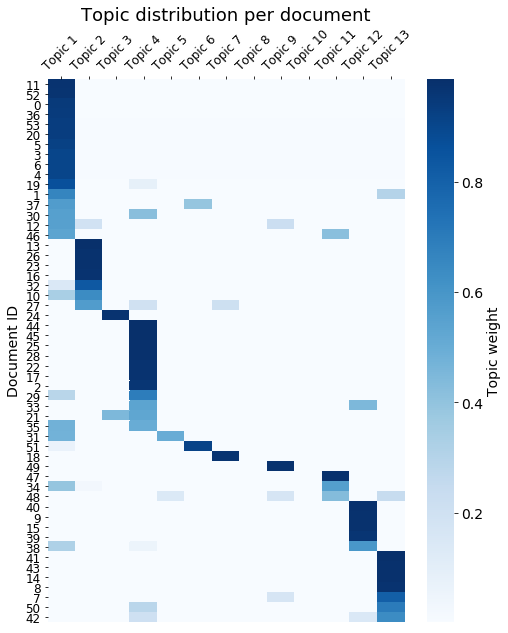

Count per class:
(array([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 11, 12]), array([16,  7,  1, 11,  1,  1,  1,  1,  3,  5,  7]))
Number of terms: 236


/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 432x288 with 0 Axes>

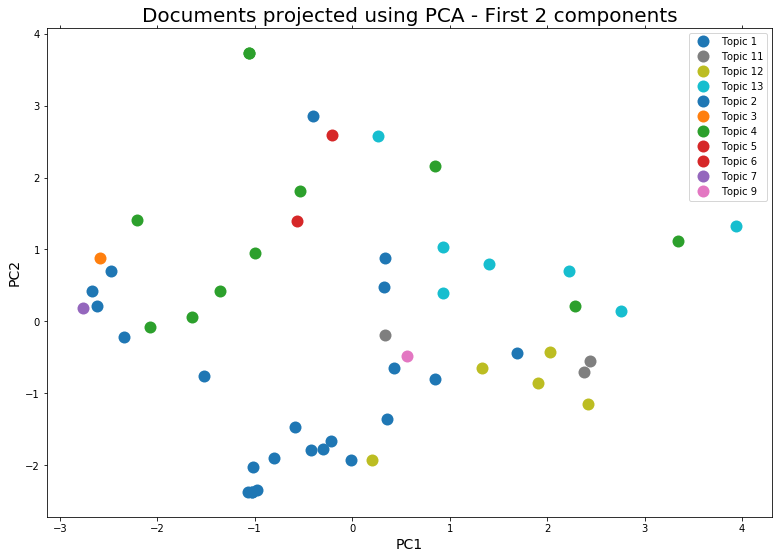

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


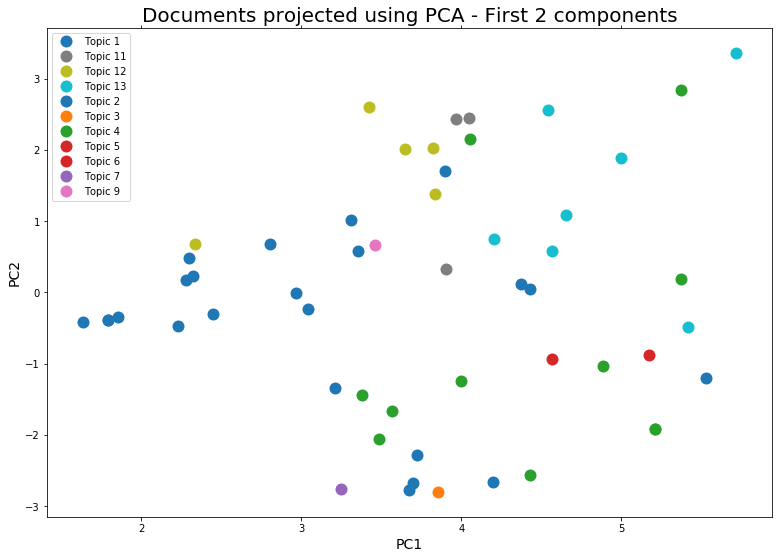

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


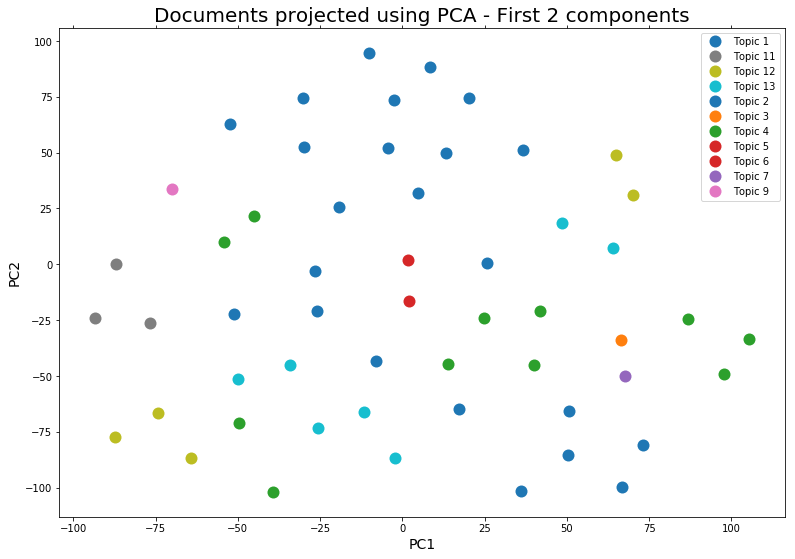

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


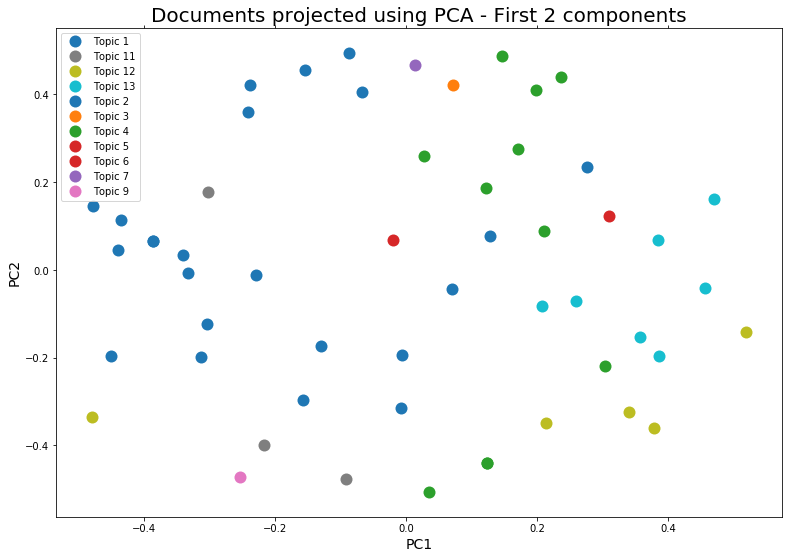

(54, 13)
(54, 54)


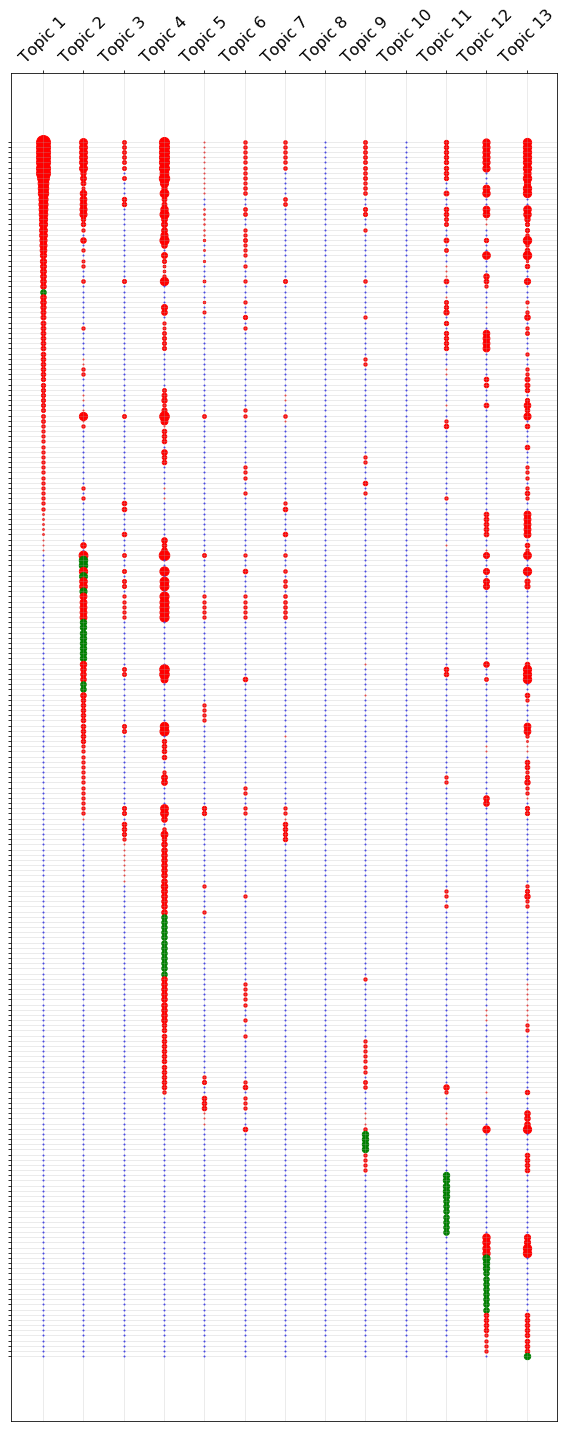

Topic #0: is_dedent, is_block, is_block is_indent, is_indent, def, return, is_op_arit, is_number, is_op_arit is_number, is_list
Topic #1: if, False, True, is_dedent is_dedent, is_op_logic, return, def, is_indent, is_block is_indent, is_block
Topic #2: is_indent return is_string, is_string is_dedent elif, return is_string, return is_string is_dedent, is_string is_dedent is_dedent, is_block is_indent return, is_indent return, is_string is_dedent, elif, is_dedent elif
Topic #3: if, is_number, return, def, is_indent, is_block, is_block is_indent, is_dedent, is_op_logic, is_number is_block
Topic #4: is_op_logic is_string is_block, is_op_logic is_string, is_string is_block is_indent, is_dedent elif, elif, is_string is_block, if, is_op_logic, is_number is_dedent elif, is_attribution is_number is_op_arit
Topic #5: is_dedent is_dedent return, is_dedent is_dedent, is_number for, is_attribution is_list, is_list is_number, is_dedent return, in, for, is_attribution, is_list
Topic #6: is_indent retu

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.072527  0.215493       1        1  17.843453
1     -0.039932 -0.210067       2        1  12.762348
2      0.166628 -0.007066       3        1   2.635729
3      0.076858  0.056808       4        1  24.685155
4      0.152428 -0.173178       5        1   1.623669
5     -0.006059 -0.115625       6        1   3.163911
6      0.163822 -0.032523       7        1   2.055686
7      0.006749 -0.033888       8        1   0.204677
8     -0.205623 -0.087123       9        1   3.155922
9      0.006750 -0.033888      10        1   0.204677
10     0.110203  0.235565      11        1   5.290184
11    -0.233097  0.129685      12        1  10.013521
12    -0.126200  0.055808      13        1  16.361068, topic_info=    Category       Freq                            Term      Total  loglift  \
37   Default  30.000000                              if  30.000000  30.0000   
156  Default  24.000000                     is_op_logic  24.000000  29.0000   
73   Default  17.000000       is_block is_indent return  17.000000  28.0000   
115  Default  17.000000                is_indent return  17.000000  27.0000   
94   Default  27.000000             is_dedent is_dedent  27.000000  26.0000   
20   Default  15.000000                            else  15.000000  25.0000   
91   Default  15.000000         is_dedent else is_block  15.000000  24.0000   
90   Default  15.000000                  is_dedent else  15.000000  23.0000   
22   Default  15.000000         else is_block is_indent  15.000000  22.0000   
21   Default  15.000000                   else is_block  15.000000  21.0000   
88   Default  12.000000                  is_dedent elif  12.000000  20.0000   
18   Default  12.000000                            elif  12.000000  19.0000   
109  Default  20.000000                    is_indent if  20.000000  18.0000   
70   Default  20.000000           is_block is_indent if  20.000000  17.0000   
208  Default  10.000000                return is_string  10.000000  16.0000   
162  Default  22.000000                       is_string  22.000000  15.0000   
57   Default  14.000000          is_attribution is_list  14.000000  14.0000   
146  Default  37.000000                      is_op_arit  37.000000  13.0000   
132  Default  20.000000    is_number is_block is_indent  20.000000  12.0000   
131  Default  20.000000              is_number is_block  20.000000  11.0000   
127  Default  37.000000                       is_number  37.000000  10.0000   
170  Default   7.000000             is_string is_dedent   7.000000   9.0000   
157  Default  15.000000           is_op_logic is_number  15.000000   8.0000   
159  Default  14.000000  is_op_logic is_number is_block  14.000000   7.0000   
87   Default  50.000000                       is_dedent  50.000000   6.0000   
66   Default  50.000000                        is_block  50.000000   5.0000   
67   Default  50.000000              is_block is_indent  50.000000   4.0000   
104  Default  50.000000                       is_indent  50.000000   3.0000   
15   Default  50.000000                             def  50.000000   2.0000   
201  Default  50.000000                          return  50.000000   1.0000   
..       ...        ...                             ...        ...      ...   
177  Topic13   1.962062                           items   4.456684   0.9899   
178  Topic13   1.962062            items is_attribution   4.456684   0.9899   
86   Topic13   1.962062        is_class split is_string   4.456684   0.9899   
208  Topic13   4.457683                return is_string  10.271673   0.9755   
200  Topic13   1.875915       range is_number is_number   4.432242   0.9505   
58   Topic13   3.529452      is_attribution is_list for   9.068398   0.8666   
96   Topic13   6.530964      is_dedent is_dedent return  17.214917   0.8410   
122  Topic13   3.529452                     is_list for   9.068398

In [22]:
# Get experiment conditions
exp_id = 8424
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
print("Number of terms: %d" % clustering.X.shape[1])
sample, y = plot_reduction(clustering, method, exp_id)
pdf(sample, y, clustering, method, exp_id)
# plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,22))
# plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(8,20), topics=[5,7,9,11], cutoff=True, ylabel=False)
plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(8,20), cutoff=True, 
                     ylabel=False, mark_exclusive=True)
print_top_words(clustering.model, feature_names, 10)
panel = LDAvis(solutions, where_items, model, R=30)
panel

# Experiment 24

- Min DF: 0.05
- Binary: True
- Vectorizer: Count
- Method: NMF
- Best k: 15

Conditions
('CountVectorizer', 0.05, True, 'euclidean', 'lda', 'dataset9', 12)


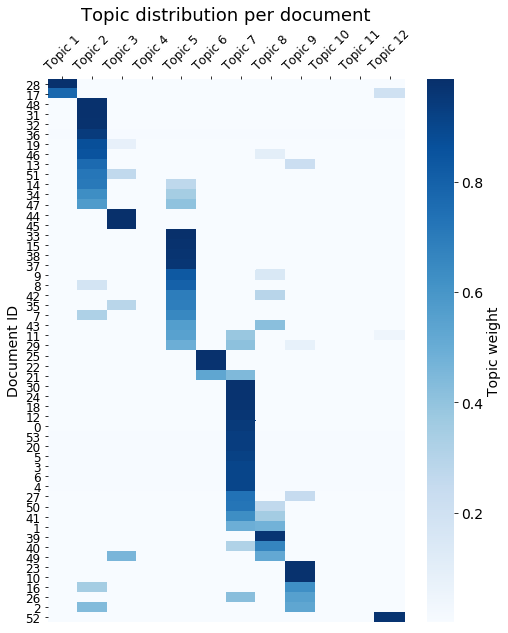

Count per class:
(array([ 0,  1,  2,  4,  5,  6,  7,  8, 11]), array([ 2, 11,  2, 12,  3, 15,  3,  5,  1]))


/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 432x288 with 0 Axes>

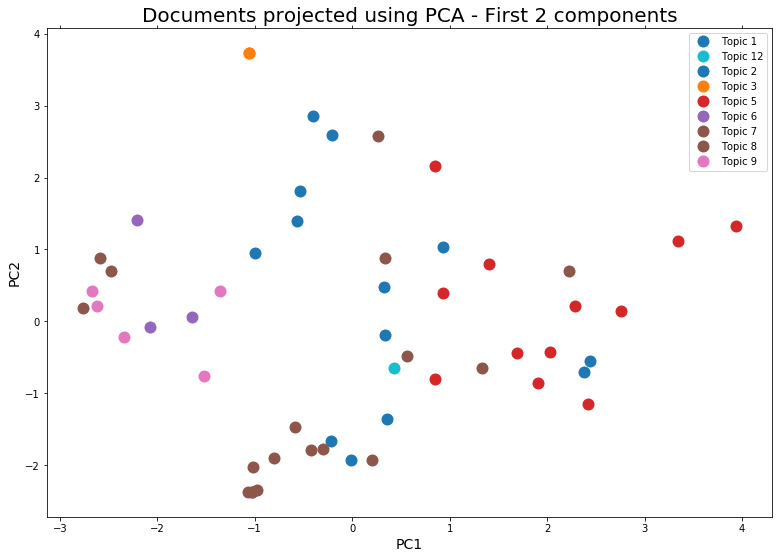

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


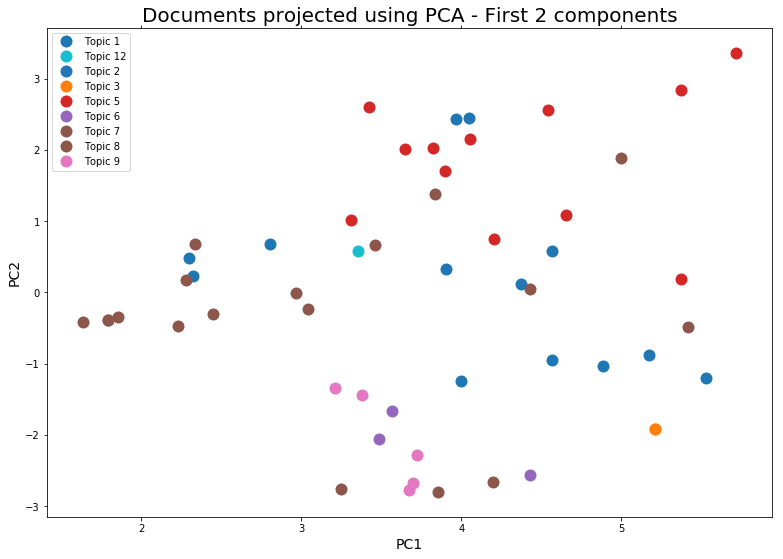

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


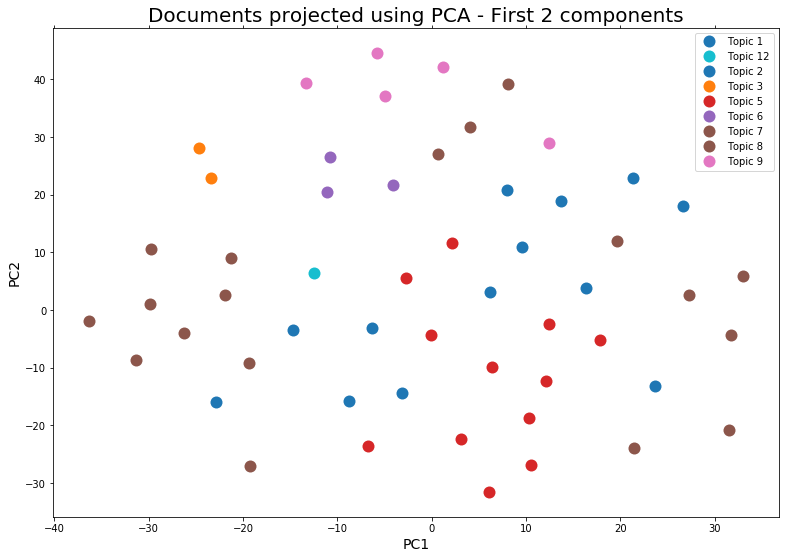

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


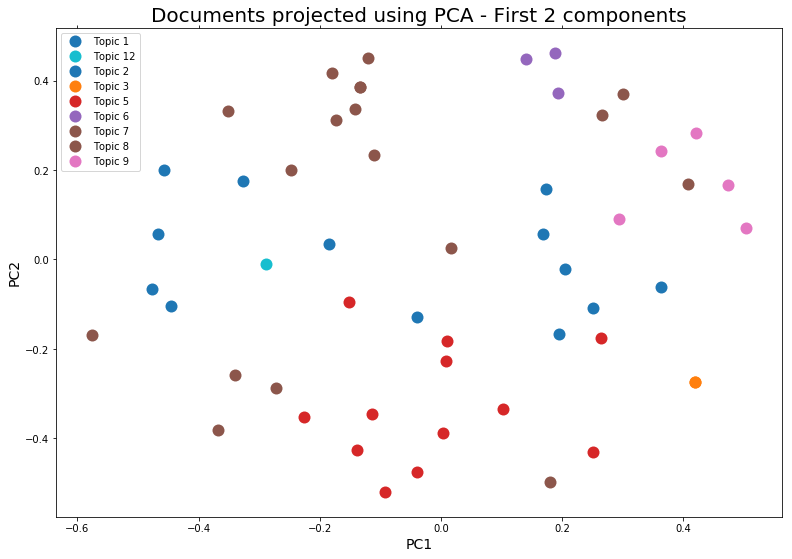

(54, 12)
(54, 54)


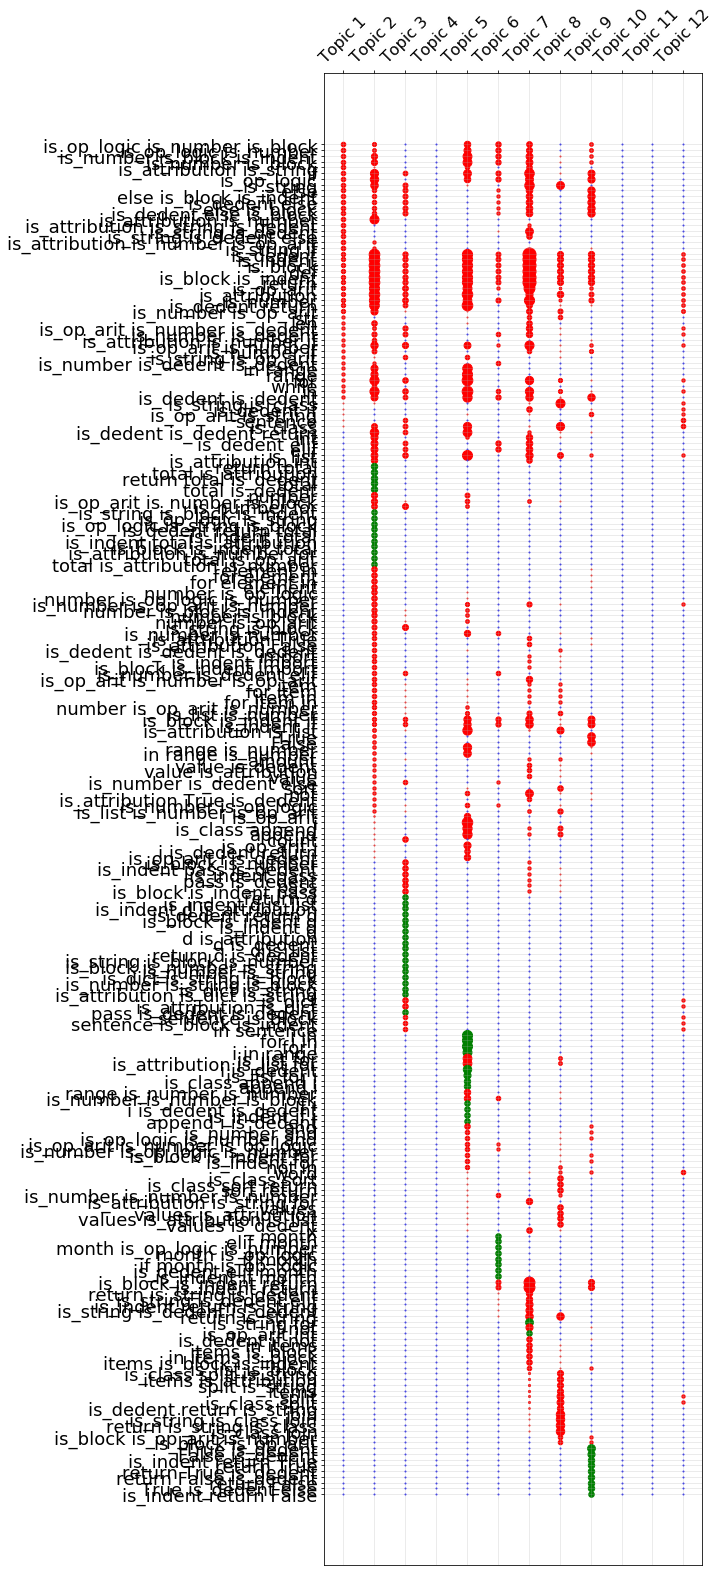

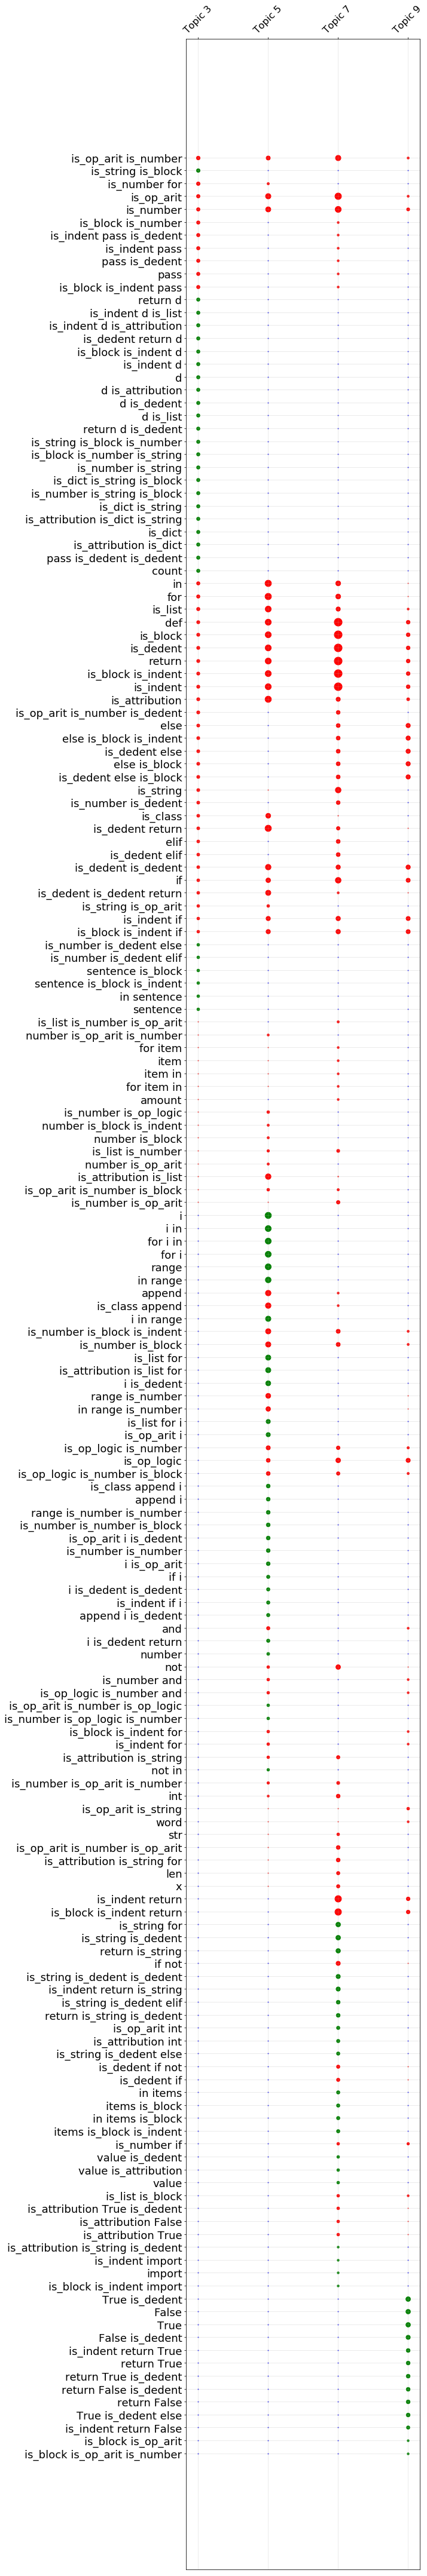

Topic #0: is_op_logic is_number is_block, is_op_logic is_number, is_number is_block is_indent, is_number is_block, is_attribution is_string, if, is_op_logic, is_string, else, else is_block is_indent
Topic #1: is_indent, is_block is_indent, return, is_dedent, is_block, def, is_attribution, is_number, is_op_arit, is_dedent return
Topic #2: is_op_arit is_number, is_string is_block, is_number for, is_op_arit, is_number, is_block is_number, is_block is_indent pass, is_indent pass is_dedent, pass is_dedent, pass
Topic #3: amount, is_op_arit, is_block, def, is_dedent, is_block is_indent, return, is_indent, count, item
Topic #4: for, in, is_dedent return, i, is_attribution, def, is_block, is_dedent, return, is_block is_indent
Topic #5: month is_op_logic is_number, month is_op_logic, month, if month is_op_logic, if month, is_dedent elif month, is_indent if month, elif month, is_op_logic is_number is_block, is_op_logic is_number
Topic #6: def, is_block, is_dedent, return, is_block is_indent, is_

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.094720  0.024224       1        1   3.848998
1      0.104011 -0.072018       2        1  19.405497
2     -0.212031  0.104207       3        1   9.408350
3     -0.083688 -0.008808       4        1   0.221734
4      0.204390 -0.141905       5        1  21.530227
5      0.170067  0.138523       6        1   5.199145
6      0.079055  0.114799       7        1  20.884756
7     -0.116315 -0.278724       8        1   9.016526
8      0.006772  0.250029       9        1   8.008536
9     -0.083688 -0.008808      10        1   0.221734
10    -0.083688 -0.008808      11        1   0.221734
11    -0.079606 -0.112712      12        1   2.032765, topic_info=Empty DataFrame
Columns: [Category, Freq, Term, Total, loglift, logprob]
Index: [], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=0, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [24]:
# Get experiment conditions
exp_id = 15142
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
sample, y = plot_reduction(clustering, method, exp_id)
pdf(sample, y, clustering, method, exp_id)
plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,22), mark_exclusive=True)
plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,60), topics=[2,4,6,8], cutoff=True, mark_exclusive=True)
print_top_words(clustering.model, feature_names, 10)
panel = LDAvis(solutions, where_items, model)
panel